### Imports
Core Python, data/plot libs, NLP tools, sklearn, and TensorFlow/Keras for deep learning.


In [28]:
import pandas as pd
import re
import random
import warnings
import string
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, roc_auc_score,
    average_precision_score, auc
)

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks


### Load dataset
Reads the SMS spam dataset, handles encoding, and maps columns to `Category` and `Message`.


In [29]:
DATASET_PATH = r"D:\Project NLP\SPAM text message 20170820 - Data (1).csv"
try:
    df = pd.read_csv(DATASET_PATH, encoding="latin-1")
except Exception:
    df = pd.read_csv(DATASET_PATH)

cols_lower = {c.lower(): c for c in df.columns}
if "category" in cols_lower and "message" in cols_lower:
    cat_col, msg_col = cols_lower["category"], cols_lower["message"]
elif "v1" in cols_lower and "v2" in cols_lower:
    cat_col, msg_col = cols_lower["v1"], cols_lower["v2"]
else:
    possible_cat = [c for c in df.columns if c.lower() in ("category","label","class") or "cat" in c.lower()]
    possible_msg = [c for c in df.columns if c.lower() in ("message","text","sms")]
    cat_col = possible_cat[0] if possible_cat else df.columns[0]
    msg_col = possible_msg[0] if possible_msg else df.columns[1]

df = df[[cat_col, msg_col]].rename(columns={cat_col:"Category", msg_col:"Message"}).dropna()


### Normalize labels
Standardizes labels to lowercase and keeps only `ham`/`spam`.


In [30]:
DATASET_PATH = r"D:\Project NLP\SPAM text message 20170820 - Data (1).csv"
try:
    df = pd.read_csv(DATASET_PATH, encoding="latin-1")
except Exception:
    df = pd.read_csv(DATASET_PATH)

cols_lower = {c.lower(): c for c in df.columns}
if "category" in cols_lower and "message" in cols_lower:
    cat_col, msg_col = cols_lower["category"], cols_lower["message"]
elif "v1" in cols_lower and "v2" in cols_lower:
    cat_col, msg_col = cols_lower["v1"], cols_lower["v2"]
else:
    possible_cat = [c for c in df.columns if c.lower() in ("category","label","class") or "cat" in c.lower()]
    possible_msg = [c for c in df.columns if c.lower() in ("message","text","sms")]
    cat_col = possible_cat[0] if possible_cat else df.columns[0]
    msg_col = possible_msg[0] if possible_msg else df.columns[1]

df = df[[cat_col, msg_col]].rename(columns={cat_col:"Category", msg_col:"Message"}).dropna()


### Class balance
Visualize the distribution of ham vs spam.


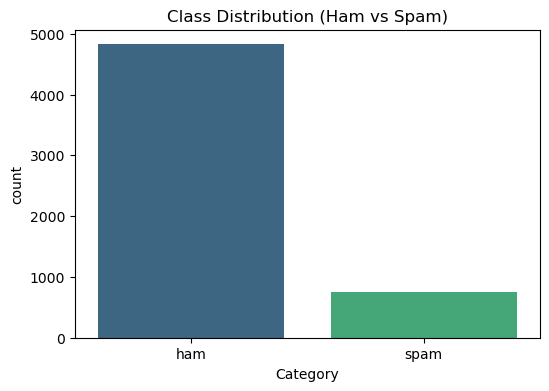

Ham:  86.59%
Spam: 13.41%


In [31]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=df, x='Category', hue='Category', palette='viridis', ax=ax)
ax.set_title("Class Distribution (Ham vs Spam)")
plt.show()

vc = df["Category"].value_counts()
ham_count = vc.get('ham', 0)
spam_count = vc.get('spam', 0)
total_count = df.shape[0]
print(f"Ham:  {ham_count/total_count*100:.2f}%")
print(f"Spam: {spam_count/total_count*100:.2f}%")


### Quick lexical EDA
Most common tokens and word clouds for spam vs ham.


Top 20 words in spam: [('to', 686), ('a', 378), ('call', 344), ('you', 287), ('your', 263), ('free', 216), ('for', 203), ('the', 201), ('now', 189), ('or', 188), ('2', 173), ('is', 157), ('txt', 150), ('u', 145), ('on', 145), ('ur', 144), ('have', 132), ('from', 128), ('mobile', 123), ('and', 122)]
Top 20 words in non-spam: [('i', 2194), ('you', 1841), ('to', 1562), ('the', 1129), ('a', 1064), ('u', 985), ('and', 849), ('in', 815), ('me', 761), ('my', 747), ('is', 735), ('it', 594), ('of', 525), ('for', 507), ('that', 488), ('im', 451), ('have', 441), ('but', 425), ('your', 414), ('so', 413)]


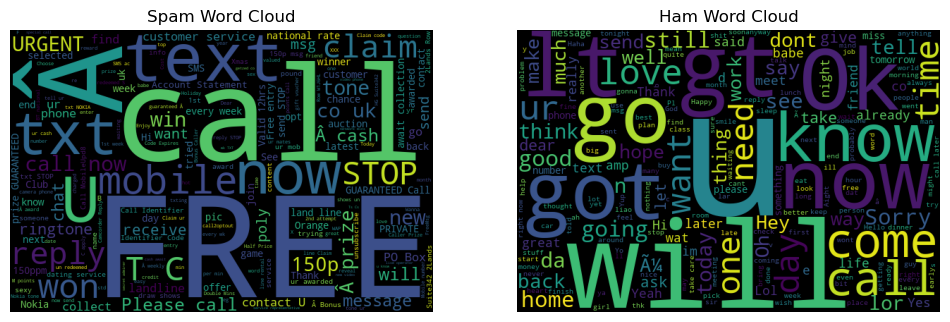

In [32]:
def get_most_common_words(messages, n=20):
    all_words = ' '.join(messages).lower()
    all_words = all_words.translate(str.maketrans('', '', string.punctuation))
    words = all_words.split()
    return Counter(words).most_common(n)

print("Top 20 words in spam:", get_most_common_words(df[df['Category']=='spam']['Message']))
print("Top 20 words in non-spam:", get_most_common_words(df[df['Category']=='ham']['Message']))

spam_words = ' '.join(df[df['Category']=='spam']['Message'])
ham_words  = ' '.join(df[df['Category']=='ham']['Message'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400).generate(spam_words))
plt.title("Spam Word Cloud")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400).generate(ham_words))
plt.title("Ham Word Cloud")
plt.axis('off')
plt.show()


### Reproducibility and split
Stratified 80/20 train/test split; labels encoded as 0=ham, 1=spam.


In [33]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(
    df['Message'],
    df['Category'],
    test_size=0.2,
    stratify=df['Category'],
    random_state=SEED
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])
print("Spam % in Train:", y_train.mean()*100)
print("Spam % in Test :", y_test.mean()*100)


Train size: 4457
Test size : 1115
Spam % in Train: 13.417096701817366
Spam % in Test : 13.363228699551568


### Cleaner
Lowercase, remove non-alphanumeric (keep digits), normalize whitespace.


In [34]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^0-9a-zA-Z]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

X_train_clean = X_train.apply(clean_text)
X_test_clean  = X_test.apply(clean_text)

print(X_train_clean.iloc[0])
print(X_test_clean.iloc[0])


he will you guys close
no need to buy lunch for me i eat maggi mee


### TF-IDF features
Build a 5k-feature TF-IDF on train; transform test.


In [35]:
tfidf = TfidfVectorizer(
    stop_words=None,
    max_features=5000,
    token_pattern=r'(?u)\b\w+\b',
    lowercase=False,
    preprocessor=lambda x: x
)

X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tfidf  = tfidf.transform(X_test_clean)

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape :", X_test_tfidf.shape)


Train TF-IDF shape: (4457, 5000)
Test TF-IDF shape : (1115, 5000)


### Stopwords plus Stemming
Runs LR on a stopword-removed plus Porter-stemmed variant for comparison.


In [36]:
try:
    nltk.download('stopwords', quiet=True)
except Exception:
    pass

stopset = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text_stem(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r'[^0-9a-zA-Z]+', ' ', s)
    toks = s.split()
    toks = [stemmer.stem(t) for t in toks if t not in stopset]
    return " ".join(toks)

X_train_stem = X_train.apply(clean_text_stem)
X_test_stem  = X_test.apply(clean_text_stem)

tfidf_stem = TfidfVectorizer(
    max_features=5000,
    token_pattern=r'(?u)\b\w+\b',
    lowercase=False,
    preprocessor=lambda x: x
)
Xtr_stem = tfidf_stem.fit_transform(X_train_stem)
Xte_stem = tfidf_stem.transform(X_test_stem)

lr_stem = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEED)
lr_stem.fit(Xtr_stem, y_train)
y_pred_stem = lr_stem.predict(Xte_stem)

print("\n[Stemming+Stopwords] Logistic Regression")
print("Accuracy :", accuracy_score(y_test, y_pred_stem))
print("Precision:", precision_score(y_test, y_pred_stem))
print("Recall   :", recall_score(y_test, y_pred_stem))
print("F1       :", f1_score(y_test, y_pred_stem))



[Stemming+Stopwords] Logistic Regression
Accuracy : 0.9856502242152466
Precision: 0.9463087248322147
Recall   : 0.9463087248322147
F1       : 0.9463087248322147


### Logistic Regression (baseline)
Balanced LR on TF-IDF with full metrics and PR-threshold plot.


Accuracy : 0.9856502242152466
Precision: 0.9463087248322147
Recall   : 0.9463087248322147
F1 Score : 0.9463087248322147

Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.95      0.95      0.95       149

    accuracy                           0.99      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



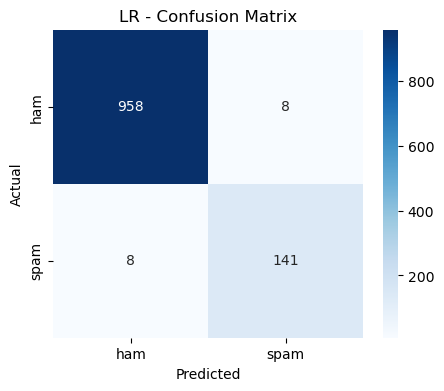

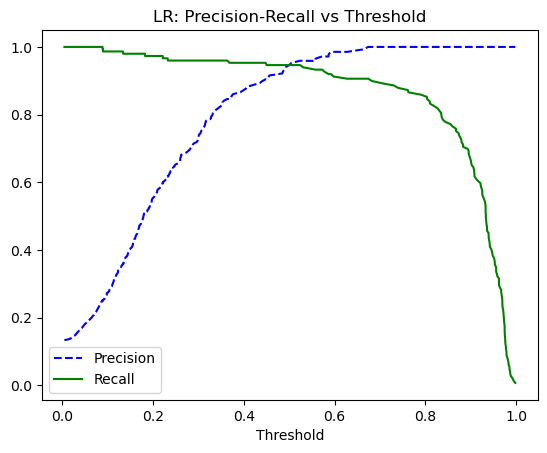

In [37]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEED)
log_reg.fit(X_train_tfidf, y_train)

y_pred = log_reg.predict(X_test_tfidf)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['ham', 'spam']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('LR - Confusion Matrix')
plt.show()

y_scores = log_reg.predict_proba(X_test_tfidf)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold"); plt.title("LR: Precision-Recall vs Threshold"); plt.legend(); plt.show()


### Predict one message (classical)
Helper that returns ham/spam with probability using TF-IDF + LR.


In [38]:
def classify_message_lr(vec: TfidfVectorizer, clf: LogisticRegression, message: str, threshold: float = 0.5):
    msg = clean_text(message)
    proba = clf.predict_proba(vec.transform([msg]))[0, 1]
    label = "spam" if proba >= threshold else "ham"
    print(f"Prob(spam)={proba:.3f} → {label}")
    return label, float(proba)

_ = classify_message_lr(tfidf, log_reg, "Let’s meet for coffee tomorrow afternoon if you’re free.")
_ = classify_message_lr(tfidf, log_reg, "Congratulations! You’ve been selected for a free iPhone — click here to claim your prize now.")


Prob(spam)=0.235 → ham
Prob(spam)=0.938 → spam


### Explain LR with SHAP
Sparse-safe linear explainer over a small test subset.


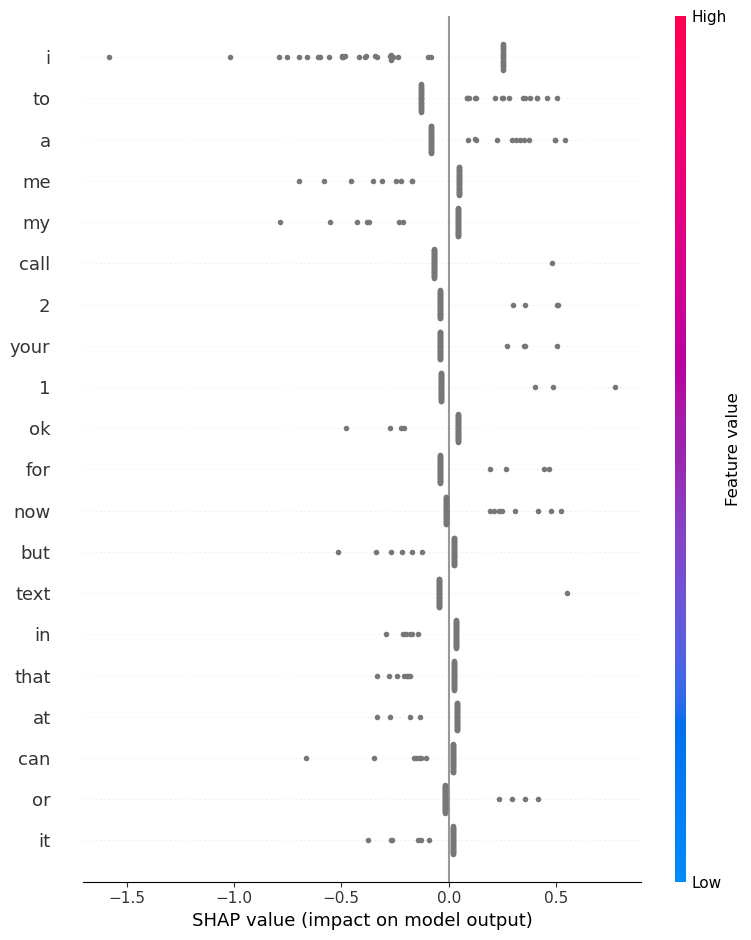

In [39]:
import shap
masker = shap.maskers.Independent(X_train_tfidf)
explainer = shap.LinearExplainer(log_reg, masker)
X_test_sub = X_test_tfidf[:50]
sv = explainer(X_test_sub)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning, message="The NumPy global RNG was seeded.*")
    shap.summary_plot(sv, feature_names=tfidf.get_feature_names_out(), show=False)
plt.show()


### Multinomial Naive Bayes
Baseline generative model on TF-IDF with full metrics.


Accuracy : 0.97
Precision: 1.00
Recall   : 0.74
F1 Score : 0.85

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



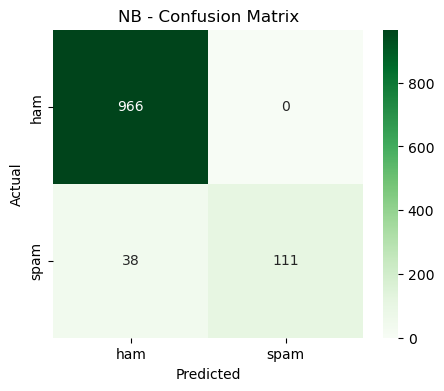

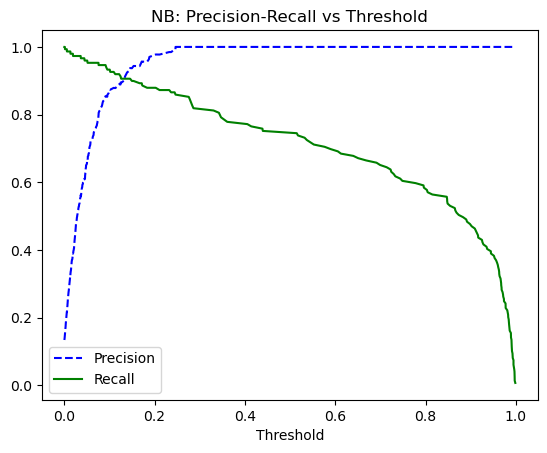

In [40]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

print(f"Accuracy : {accuracy_score(y_test, y_pred_nb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_nb):.2f}")
print(f"Recall   : {recall_score(y_test, y_pred_nb):.2f}")
print(f"F1 Score : {f1_score(y_test, y_pred_nb):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb, target_names=['ham', 'spam'], digits=2))

cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('NB - Confusion Matrix')
plt.show()

y_scores_nb = nb.predict_proba(X_test_tfidf)[:,1]
p_nb, r_nb, t_nb = precision_recall_curve(y_test, y_scores_nb)
plt.plot(t_nb, p_nb[:-1], "b--", label="Precision")
plt.plot(t_nb, r_nb[:-1], "g-",  label="Recall")
plt.xlabel("Threshold"); plt.title("NB: Precision-Recall vs Threshold"); plt.legend(); plt.show()


### Linear SVM
Balanced LinearSVC on TF-IDF with full metrics.


Accuracy : 0.99
Precision: 0.98
Recall   : 0.93
F1 Score : 0.95

Classification Report:
               precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.98      0.93      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



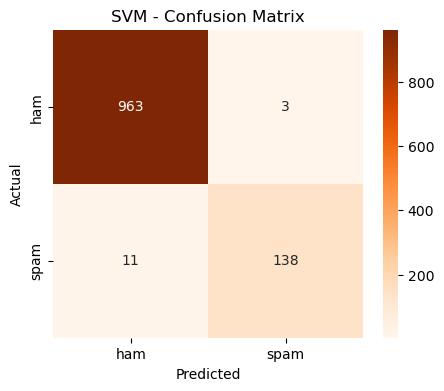

In [41]:
svm_clf = LinearSVC(class_weight='balanced', random_state=SEED)
svm_clf.fit(X_train_tfidf, y_train)
y_pred_svm = svm_clf.predict(X_test_tfidf)

print(f"Accuracy : {accuracy_score(y_test, y_pred_svm):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.2f}")
print(f"Recall   : {recall_score(y_test, y_pred_svm):.2f}")
print(f"F1 Score : {f1_score(y_test, y_pred_svm):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm, target_names=['ham', 'spam'], digits=2))

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('SVM - Confusion Matrix')
plt.show()


### Results table
Accuracy, Precision, Recall, F1 for LR, NB, SVM, plus a bar chart.


                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression      0.99       0.95    0.95      0.95
1          Naive Bayes      0.97       1.00    0.74      0.85
2                  SVM      0.99       0.98    0.93      0.95


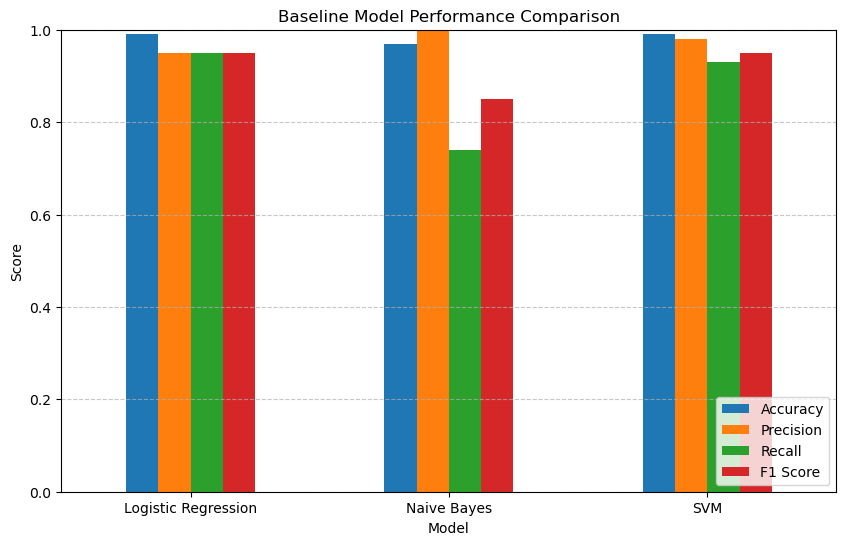

In [42]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'SVM'],
    'Accuracy': [
        round(accuracy_score(y_test, log_reg.predict(X_test_tfidf)), 2),
        round(accuracy_score(y_test, nb.predict(X_test_tfidf)), 2),
        round(accuracy_score(y_test, svm_clf.predict(X_test_tfidf)), 2)
    ],
    'Precision': [
        round(precision_score(y_test, log_reg.predict(X_test_tfidf)), 2),
        round(precision_score(y_test, nb.predict(X_test_tfidf)), 2),
        round(precision_score(y_test, svm_clf.predict(X_test_tfidf)), 2)
    ],
    'Recall': [
        round(recall_score(y_test, log_reg.predict(X_test_tfidf)), 2),
        round(recall_score(y_test, nb.predict(X_test_tfidf)), 2),
        round(recall_score(y_test, svm_clf.predict(X_test_tfidf)), 2)
    ],
    'F1 Score': [
        round(f1_score(y_test, log_reg.predict(X_test_tfidf)), 2),
        round(f1_score(y_test, nb.predict(X_test_tfidf)), 2),
        round(f1_score(y_test, svm_clf.predict(X_test_tfidf)), 2)
    ]
})
print(results)

results.set_index('Model').plot(kind='bar', figsize=(10,6))
plt.title("Baseline Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

models = {"Logistic Regression": log_reg, "Naive Bayes": nb, "SVM": svm_clf}


### Progressive training-size evaluation
LR trained on increasing subsets of train; evaluated on full test.


In [43]:
sizes = [500, 1000, 2000, 3000, len(X_train_clean)]
records = []
for n in sizes:
    n = min(n, len(X_train_clean))
    Xn = X_train_clean.iloc[:n]
    yn = y_train.iloc[:n]

    tfidf_sub = TfidfVectorizer(
        stop_words=None, max_features=5000,
        token_pattern=r'(?u)\b\w+\b', lowercase=False, preprocessor=lambda x: x
    )
    Xn_tfidf = tfidf_sub.fit_transform(Xn)
    Xte_sub  = tfidf_sub.transform(X_test_clean)

    clf_ = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEED)
    clf_.fit(Xn_tfidf, yn)
    yp_ = clf_.predict(Xte_sub)

    records.append({"Train_n": n, "Test_F1": f1_score(y_test, yp_), "Test_Acc": accuracy_score(y_test, yp_)})

pd.DataFrame(records)


,Train_n,Test_F1,Test_Acc
0,500,0.890411,0.971300
1,1000,0.910345,0.976682
2,2000,0.929293,0.981166
3,3000,0.936027,0.982960
4,4457,0.946309,0.985650


### ROC/PR AUC and ROC curves
AUCs for classical models and ROC curves.


LR: ROC-AUC=0.989  PR-AUC=0.974
NB: ROC-AUC=0.983  PR-AUC=0.965
SVM: ROC-AUC=0.989  PR-AUC=0.975


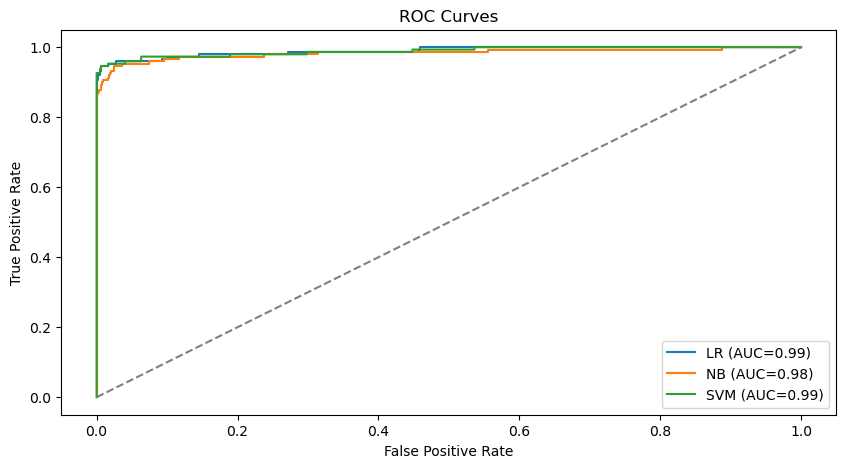

In [44]:
from sklearn.metrics import roc_auc_score, average_precision_score

def _scores(model, X):
    return model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X)

def aucs(model, X, y):
    s = _scores(model, X)
    return roc_auc_score(y, s), average_precision_score(y, s)

for name, mdl in {"LR": log_reg, "NB": nb, "SVM": svm_clf}.items():
    rauc, prauc = aucs(mdl, X_test_tfidf, y_test)
    print(f"{name}: ROC-AUC={rauc:.3f}  PR-AUC={prauc:.3f}")

plt.figure(figsize=(10, 5))
for name, mdl in {"LR": log_reg, "NB": nb, "SVM": svm_clf}.items():
    y_scores = _scores(mdl, X_test_tfidf)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curves")
plt.legend(); plt.show()


### Learning curves (5-fold CV)
Cross-validated learning curves for LR, NB, SVM using F1.


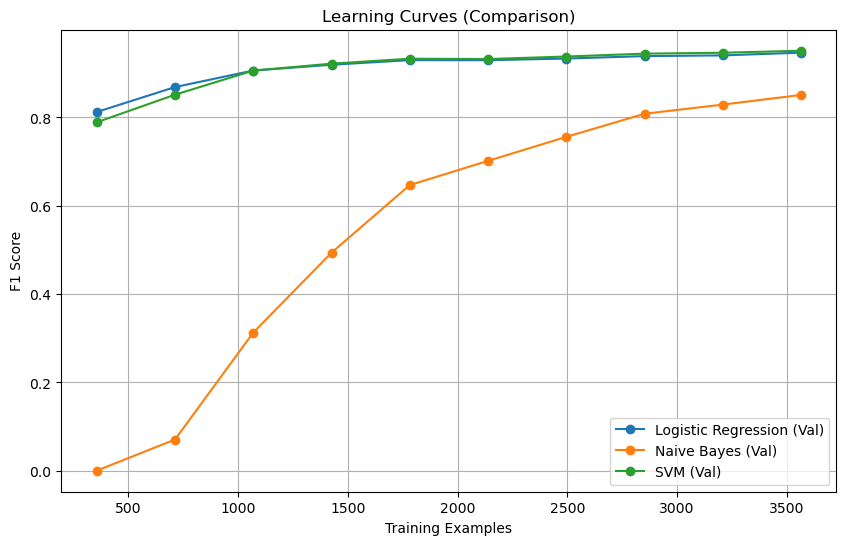

In [45]:
models = {"Logistic Regression": log_reg, "Naive Bayes": nb, "SVM": svm_clf}

plt.figure(figsize=(10,6))
for name, model in models.items():
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_tfidf, y_train,
        cv=5, scoring="f1",
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )
    plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label=f"{name} (Val)")

plt.xlabel("Training Examples"); plt.ylabel("F1 Score"); plt.title("Learning Curves (Comparison)")
plt.legend(); plt.grid(True); plt.show()


### Salient features
Top indicative tokens for LR, SVM, and NB.


In [46]:
feature_names = np.array(tfidf.get_feature_names_out())

def get_top_features(coefs, n=15):
    top_spam = feature_names[np.argsort(coefs)[-n:]]
    top_ham  = feature_names[np.argsort(coefs)[:n]]
    return top_spam, top_ham

log_coefs = log_reg.coef_[0]
log_spam, log_ham = get_top_features(log_coefs)

svm_coefs = svm_clf.coef_[0]
svm_spam, svm_ham = get_top_features(svm_coefs)

nb_feature_log_prob = nb.feature_log_prob_
nb_spam = feature_names[np.argsort(nb_feature_log_prob[1])[-15:]]
nb_ham  = feature_names[np.argsort(nb_feature_log_prob[0])[-15:]]

print("Logistic Regression - Top Spam:", log_spam)
print("Logistic Regression - Top Ham :", log_ham)
print("SVM - Top Spam:", svm_spam)
print("SVM - Top Ham :", svm_ham)
print("Naive Bayes - Top Spam:", nb_spam)
print("Naive Bayes - Top Ham :", nb_ham)

df_features = pd.DataFrame({
    "LogReg_Spam": log_spam,
    "LogReg_Ham": log_ham,
    "SVM_Spam": svm_spam,
    "SVM_Ham": svm_ham,
    "NB_Spam": nb_spam,
    "NB_Ham": nb_ham
})
print(df_features)


Logistic Regression - Top Spam: ['claim' 'won' '2' '150p' 'mobile' 'www' 'to' 'reply' '1' 'stop' 'free'
 'uk' 'text' 'txt' 'call']
Logistic Regression - Top Ham : ['i' 'me' 'my' 'lt' 'gt' 'ok' 'that' 'but' 'he' 'da' 'come' 'll' 'when'
 'later' 'up']
SVM - Top Spam: ['call' 'service' 'com' '2' 'stop' 'reply' 'chat' '1' 'mobile' 'text'
 '150p' 'error' 'won' 'uk' 'txt']
SVM - Top Ham : ['i' 'me' 'lt' 'gt' 'fullonsms' 'my' 'up' 'he' 'sir' 'that' 'then' 'k'
 'yup' 'ok' 'but']
Naive Bayes - Top Spam: ['mobile' 'stop' 'from' 'claim' 'or' 'now' 'for' 'txt' '2' 'you' 'your'
 'free' 'a' 'call' 'to']
Naive Bayes - Top Ham : ['s' 'ok' 'that' 'is' 'it' 'and' 'my' 'me' 'a' 'in' 'the' 'u' 'to' 'you'
 'i']
   LogReg_Spam LogReg_Ham SVM_Spam    SVM_Ham NB_Spam NB_Ham
0        claim          i     call          i  mobile      s
1          won         me  service         me    stop     ok
2            2         my      com         lt    from   that
3         150p         lt        2         gt   claim   

### Deep learning: tokenization and split
Tokenize cleaned text, pad sequences, and create validation split from train.


In [47]:
tok = Tokenizer(num_words=20000, oov_token="<OOV>")
tok.fit_on_texts(X_train_clean)

def to_seq(series):
    return pad_sequences(tok.texts_to_sequences(series), maxlen=200, padding="pre", truncating="pre")

Xtr = to_seq(X_train_clean).astype(np.int32)
Xte = to_seq(X_test_clean).astype(np.int32)

y_tr = y_train.values.astype(np.float32)
y_te = y_test.values.astype(np.float32)

Xtr_tr, Xtr_val, ytr_tr, ytr_val = train_test_split(Xtr, y_tr, test_size=0.15, stratify=y_tr, random_state=SEED)

es = callbacks.EarlyStopping(monitor="val_prc", patience=2, mode="max", restore_best_weights=True)

from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=ytr_tr.ravel())
class_weights = {0: float(cw[0]), 1: float(cw[1])}


### LSTM (regularized)
Embedding = SpatialDropout = LSTM = Dense(1, sigmoid). Early stopping on validation PR-AUC.


Epoch 1/10
60/60 - 34s - 573ms/step - accuracy: 0.8833 - loss: 0.3330 - prc: 0.7962 - roc: 0.9364 - val_accuracy: 0.9701 - val_loss: 0.1132 - val_prc: 0.9476 - val_roc: 0.9821
Epoch 2/10
60/60 - 27s - 447ms/step - accuracy: 0.9871 - loss: 0.0854 - prc: 0.9774 - roc: 0.9915 - val_accuracy: 0.9821 - val_loss: 0.0659 - val_prc: 0.9748 - val_roc: 0.9940
Epoch 3/10
60/60 - 24s - 400ms/step - accuracy: 0.9934 - loss: 0.0483 - prc: 0.9883 - roc: 0.9968 - val_accuracy: 0.9865 - val_loss: 0.0551 - val_prc: 0.9796 - val_roc: 0.9955
Epoch 4/10
60/60 - 23s - 390ms/step - accuracy: 0.9960 - loss: 0.0354 - prc: 0.9909 - roc: 0.9988 - val_accuracy: 0.9865 - val_loss: 0.0550 - val_prc: 0.9790 - val_roc: 0.9955
Epoch 5/10
60/60 - 21s - 352ms/step - accuracy: 0.9966 - loss: 0.0232 - prc: 0.9899 - roc: 0.9989 - val_accuracy: 0.9731 - val_loss: 0.0834 - val_prc: 0.9774 - val_roc: 0.9952
LSTM — PR-AUC: 0.9805426238707176 ROC-AUC: 0.9937123959592591


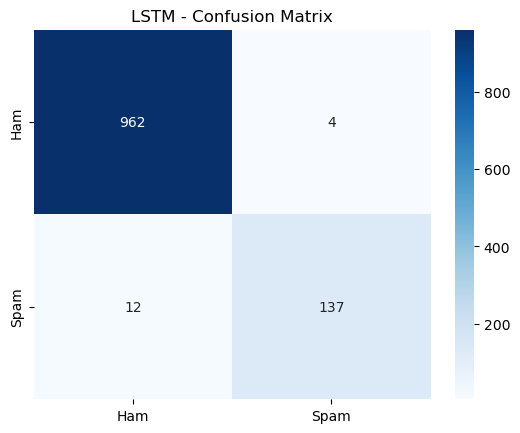

In [48]:
lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=min(20000, len(tok.word_index)+1), output_dim=128),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(128, dropout=0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
lstm.compile(
    optimizer="adam", loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(curve="ROC", name="roc"),
             tf.keras.metrics.AUC(curve="PR",  name="prc"),
             "accuracy"]
)

hist = lstm.fit(
    Xtr_tr, ytr_tr,
    validation_data=(Xtr_val, ytr_val),
    epochs=10, batch_size=64,
    callbacks=[es], class_weight=class_weights, verbose=2
)

proba_lstm = lstm.predict(Xte, verbose=0).ravel()
y_pred_lstm = (proba_lstm >= 0.5).astype(int)
print("LSTM — PR-AUC:", average_precision_score(y_te, proba_lstm),
      "ROC-AUC:", roc_auc_score(y_te, proba_lstm))

cm_lstm = confusion_matrix(y_te.astype(int), y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.title('LSTM - Confusion Matrix'); plt.show()


### Predict one message (DL)
Helper that returns ham/spam with probability using tokenizer + model.


In [49]:
def classify_message_dl(model, tok, message, threshold=0.5, max_len=200):
    seq = tok.texts_to_sequences([clean_text(message)])
    seq = pad_sequences(seq, maxlen=max_len, padding="pre", truncating="pre")
    p = float(model.predict(seq, verbose=0).ravel()[0])
    label = "spam" if p >= threshold else "ham"
    print(f"Prob(spam)={p:.3f} → {label}")
    return label, p

_ = classify_message_dl(lstm, tok, "Let’s meet for coffee tomorrow afternoon if you’re free.")
_ = classify_message_dl(lstm, tok, "Congratulations! You’ve been selected for a free iPhone — click here to claim your prize now.")


Prob(spam)=0.022 → ham
Prob(spam)=0.992 → spam


### CNN baseline
Embedding = Conv1D = GlobalMaxPool = Dropout = Dense(1, sigmoid). Early stopping on validation PR-AUC.


Epoch 1/10
60/60 - 10s - 162ms/step - accuracy: 0.9192 - loss: 0.5168 - prc: 0.7782 - roc: 0.9273 - val_accuracy: 0.9013 - val_loss: 0.3099 - val_prc: 0.9309 - val_roc: 0.9650
Epoch 2/10
60/60 - 4s - 64ms/step - accuracy: 0.9741 - loss: 0.1186 - prc: 0.9785 - roc: 0.9924 - val_accuracy: 0.9701 - val_loss: 0.0878 - val_prc: 0.9727 - val_roc: 0.9917
CNN — PR-AUC: 0.9495658112476535 ROC-AUC: 0.9846040546361527


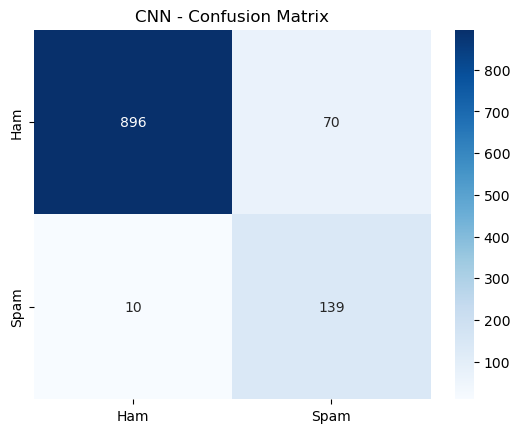

In [50]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=min(20000, len(tok.word_index)+1), output_dim=128),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn.compile(
    optimizer="adam", loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(curve="ROC", name="roc"),
             tf.keras.metrics.AUC(curve="PR",  name="prc"),
             "accuracy"]
)

hist_cnn = cnn.fit(
    Xtr_tr, ytr_tr,
    validation_data=(Xtr_val, ytr_val),
    epochs=10, batch_size=64,
    callbacks=[es], class_weight=class_weights, verbose=2
)

proba_cnn = cnn.predict(Xte, verbose=0).ravel()
y_pred_cnn = (proba_cnn >= 0.5).astype(int)
print("CNN — PR-AUC:", average_precision_score(y_te, proba_cnn),
      "ROC-AUC:", roc_auc_score(y_te, proba_cnn))

cm_cnn = confusion_matrix(y_te.astype(int), y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.title('CNN - Confusion Matrix'); plt.show()


### Threshold tuning (validation-driven)
Tune thresholds on validation to maximize F1 (optionally under a minimum recall), then evaluate on test.


LSTM tuned threshold: 0.5332096219062805
              precision    recall  f1-score   support

         ham      0.988     0.997     0.992       966
        spam      0.979     0.919     0.948       149

    accuracy                          0.987      1115
   macro avg      0.983     0.958     0.970      1115
weighted avg      0.986     0.987     0.986      1115



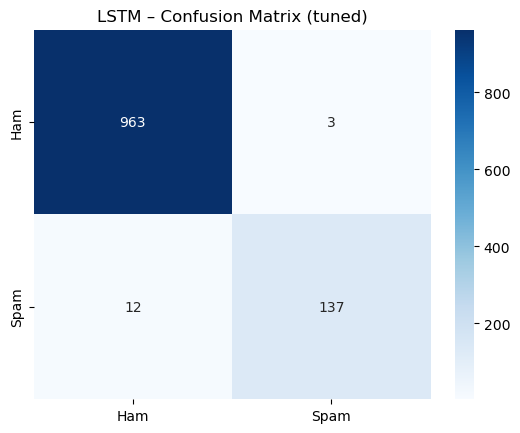

CNN tuned threshold: 0.6031984686851501
              precision    recall  f1-score   support

         ham      0.987     0.964     0.975       966
        spam      0.797     0.919     0.854       149

    accuracy                          0.958      1115
   macro avg      0.892     0.942     0.914      1115
weighted avg      0.962     0.958     0.959      1115



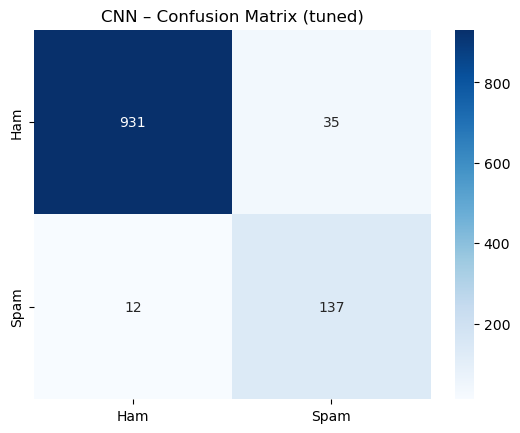

In [51]:
from sklearn.metrics import precision_recall_curve, classification_report

def tune_by_f1(scores_val, y_val, scores_test, y_test, min_recall=None):
    p, r, thr = precision_recall_curve(y_val, scores_val)
    f1 = 2*p*r/(p+r+1e-12)
    p, r, f1 = p[:-1], r[:-1], f1[:-1]
    if min_recall is not None:
        ok = np.where(r >= min_recall)[0]
        idx = ok[np.argmax(f1[ok])] if len(ok) else np.argmax(f1)
    else:
        idx = np.argmax(f1)
    th = float(thr[idx])
    yhat = (scores_test >= th).astype(int)
    return th, yhat

val_lstm = lstm.predict(Xtr_val, verbose=0).ravel()
te_lstm  = lstm.predict(Xte, verbose=0).ravel()
th_lstm, yhat_lstm = tune_by_f1(val_lstm, ytr_val, te_lstm, y_te, min_recall=0.90)
print("LSTM tuned threshold:", th_lstm)
print(classification_report(y_te.astype(int), yhat_lstm, target_names=['ham','spam'], digits=3))
sns.heatmap(confusion_matrix(y_te.astype(int), yhat_lstm), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.title('LSTM – Confusion Matrix (tuned)'); plt.show()

val_cnn = cnn.predict(Xtr_val, verbose=0).ravel()
te_cnn  = cnn.predict(Xte, verbose=0).ravel()
th_cnn, yhat_cnn = tune_by_f1(val_cnn, ytr_val, te_cnn, y_te, min_recall=0.90)
print("CNN tuned threshold:", th_cnn)
print(classification_report(y_te.astype(int), yhat_cnn, target_names=['ham','spam'], digits=3))
sns.heatmap(confusion_matrix(y_te.astype(int), yhat_cnn), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.title('CNN – Confusion Matrix (tuned)'); plt.show()
